Initialize environment and preprocess data.

In [1]:
import sys
sys.path.append('../src')

In [2]:
# import all libraries

import os
import shutil
import csv
import numpy as np
import openpyxl
import random
from csv import writer
from PIL import Image
from skimage import io
from midetection.Utils import echo_config
from midetection.Utils import utilities
from midetection.lib.siamese_net.siamese_net.config import EchoPaths


input_path = echo_config.raw_input_path
label_path = echo_config.raw_label_path
renamed_input_path = echo_config.renamed_input_path
renamed_label_path = echo_config.renamed_label_path
echo_paths = [echo_config.trainInput_data,
              echo_config.l_traindata,
              echo_config.testInput_data,
              echo_config.l_testdata,
              echo_config.validInput_data,
              echo_config.l_validdata]

In [3]:
#write a csv file for the labels from the given file A4C.xlsx
utilities.removeFile(echo_config.echo_labels)

dataframe = openpyxl.load_workbook(echo_config.dataset_label)
dataframe1 = dataframe.active

num_cases = int(len(os.listdir(input_path))/2)
for row in dataframe1.iter_rows(3, num_cases + 2):
    label = 0
    for col in range(0, dataframe1.max_column):
        if row[col].value == "MI":
            label = 1
            break
        
    filename = str(row[0].value).split("ES000", 1)[1].split("_", 1)[0].split(" ", 1)[0]
    with open(echo_config.echo_labels,'a+') as fd:
        writer_object = writer(fd)
        writer_object.writerow([filename,label])
        fd.close()

In [4]:
# rename echo images in following format: casenum_instance.png
# instance can be 'ed' or 'es'
for echo_path in [input_path, label_path]:
    echo_dir = sorted(os.listdir(echo_path))

    for image in echo_dir:
        image_path = echo_path + image # retrieve image path in a datapoint
        image_name = os.path.splitext(image)[0].split("ES000", 1)[1].split("_", 1)[0].split(" ", 1)[0]
        image_instance = os.path.splitext(image)[0].split("ES000", 1)[1].split("_" or " ", 3)[3]
        if echo_path == input_path:
            shutil.copy(image_path, renamed_input_path)
            os.rename(renamed_input_path + image, renamed_input_path + image_name + "_" + image_instance + ".jpg")
        else:
            shutil.copy(image_path, renamed_label_path)
            os.rename(renamed_label_path + image, renamed_label_path + image_name + "_" + image_instance + ".jpg")

In [5]:
for path in echo_paths:
    path_dir = os.listdir(path)
    for file in path_dir:
        try:
            shutil.rmtree(path + file)
        except OSError:
            os.remove(path + file)

In [6]:
utilities.removeFile(EchoPaths.training_csv)
utilities.removeFile(EchoPaths.validating_csv)
utilities.removeFile(EchoPaths.testing_csv)

def get_label(case_num):
	label = 0
	with open(echo_config.echo_labels, mode ='r') as file: 
		csvFile = csv.reader(file)
		for row in csvFile:
				if row[0] == case_num:
					label = row[1]
		file.close()
	return label

In [7]:
# split data into training and testing sets
test_size = 0.25
input_dir = sorted(os.listdir(renamed_input_path))
label_dir = sorted(os.listdir(renamed_label_path))

random.shuffle(input_dir)
num_input = len(input_dir)
indices = list(range(num_input))
split = int(np.floor(test_size * num_input))
# print("Split at index '%i'." % split)
print(str(split) + " images for testing and " + str(num_input-split) + " for training.")

# copy some into folder for testing and training
count = 0
for image in input_dir:
    if (image not in os.listdir(echo_paths[0])) and (image not in os.listdir(echo_paths[2])):
        image_name = os.path.splitext(image)[0].split("_", 1)[0]
        label = get_label(image_name)
        if count >= split:
            shutil.copy(renamed_input_path + image_name + "_ed.jpg",echo_paths[0])
            shutil.copy(renamed_label_path + image_name + "_ed.jpg",echo_paths[1])
            shutil.copy(renamed_input_path + image_name + "_es.jpg",echo_paths[0])
            shutil.copy(renamed_label_path + image_name + "_es.jpg",echo_paths[1])
        elif count < split:
            shutil.copy(renamed_input_path + image_name + "_ed.jpg",echo_paths[2])
            shutil.copy(renamed_label_path + image_name + "_ed.jpg",echo_paths[3])
            shutil.copy(renamed_input_path + image_name + "_es.jpg",echo_paths[2])
            shutil.copy(renamed_label_path + image_name + "_es.jpg",echo_paths[3])
            with open(EchoPaths.testing_csv,'a+') as fd:
                writer_object = writer(fd)
                writer_object.writerow([image_name + "_ed.png",image_name + "_es.png",label])
                fd.close()
        count += 2

54 images for testing and 164 for training.


In [8]:
# split training data into training and validating sets
train_dir = os.listdir(echo_paths[0])
random.shuffle(train_dir)
train_label_dir = sorted(os.listdir(echo_paths[1]))

valid_size = 0.15

num_training = len(train_dir)
indices = list(range(num_training))
split = int(np.floor(valid_size * num_training))
# print("Split at index '%i'." % split)
print(str(split) + " images for validating and " + str(num_training-split) + " for training.")

# copy some into folder for validating set
count = 0
for image in train_dir:
    image_name = os.path.splitext(image)[0].split("_", 1)[0]
    instance = os.path.splitext(image)[0].split("_", 1)[1]
    if image not in os.listdir(echo_paths[4]) and (instance != "es"):      
        label = get_label(image_name)
        if count < split:
            shutil.move(echo_paths[0] + image_name + "_ed.jpg", echo_paths[4])
            shutil.move(echo_paths[1] + image_name + "_ed.jpg", echo_paths[5])
            shutil.move(echo_paths[0] + image_name + "_es.jpg", echo_paths[4])
            shutil.move(echo_paths[1] + image_name + "_es.jpg", echo_paths[5])
            with open(EchoPaths.validating_csv,'a+') as fd:
                writer_object = writer(fd)
                writer_object.writerow([image_name + "_ed.png",image_name + "_es.png",label])
                fd.close()
        elif count>= split:
            with open(EchoPaths.training_csv,'a+') as fd:
                writer_object = writer(fd)
                writer_object.writerow([image_name + "_ed.png",image_name + "_es.png",label])
                fd.close()
        count += 2

24 images for validating and 140 for training.


In [9]:
# preprocess the images - resizing and renaming

for echo_path in echo_paths:
    echo_dir = sorted(os.listdir(echo_path))

    for image in echo_dir:
        image_path = echo_path + "/" + image  # retrieve image path in a datapoint
        #print(image_path)
        Img = Image.open(image_path)
        width,height = Img.size
        Img = Img.resize((224,224)) # (636,422) ; resize image into (224,224)
        Img.save(image_path)    # replace original image with resized image
        Img.close()
        img = io.imread(image_path)
        #print(img.ndim)
        save_path = echo_path + os.path.splitext(image)[0] + ".png"
        #io.imsave(save_path,img) # use this if no need to grayscale
        os.rename(image_path, save_path)

Train Segmentation Model and Evaluate

Successfully created the logger directory ./logger
selected device is  cuda:0
Setting model parameters
Creating folders for every data
Training ongoing...


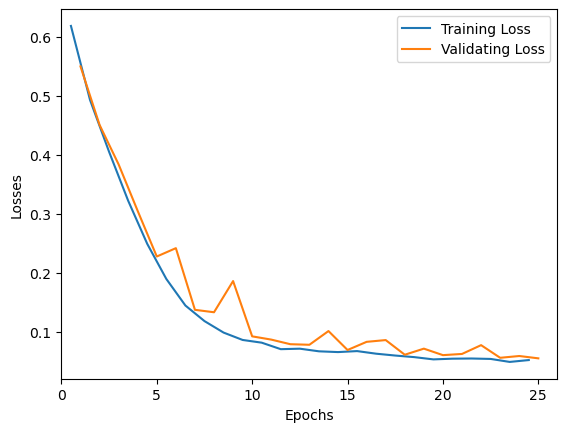

Testing the model...
Dice Score : 0.5260752890270918


In [10]:
# lr min at 1e-6, attention u-net, n1=32, added layer of e-d, and added tensorboard graph of training and validation losses

from midetection.lib.UNet.pytorch_run import run_model

test_data_paths = [echo_paths[2] + sorted(os.listdir(echo_paths[2]))[0], echo_paths[3] + sorted(os.listdir(echo_paths[3]))[0]]

run_model(batch_size=4, epoch=25, base_paths=echo_paths + test_data_paths)

Quantify wall motion and myocardial thickening

In [11]:
from midetection.quantify.quantify_echo import get_centerAndThicknessOfAllSegments, measure_wallMotion, measure_myocardialThickening

centers, thickness, image_index = get_centerAndThicknessOfAllSegments()
wallMotion = measure_wallMotion(centers, image_index)
myocardialThickening = measure_myocardialThickening(thickness, image_index)

Center and thickness of all segments acquired.
Wall motion measured for all segments.
Myocardial thickening measured for all segments.


Train and test MI classifier

2024-05-12 15:00:01.093935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 15:00:03.353455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 15:00:05.435044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training the model...


/home/laballais/miniconda3/envs/mi-detection/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Testing the model...


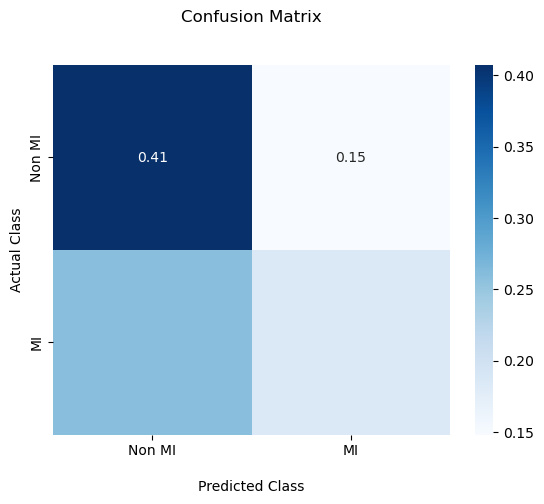


Accuracy: 59.25925925925925 %
Sensitivity: 55.55554938271674 %
Precision: 41.66666319444474 %
Specificity: 61.111107716049574 %


In [12]:
# LR=1e-4 epoch=400 batch_size=2 with early stopping
from midetection.lib.siamese_net.siamese_net.train_bce import train_model, test_model
from midetection.lib.siamese_net.siamese_net.utils import normalize_data1

wallMotion = normalize_data1(wallMotion)
myocardialThickening = normalize_data1(myocardialThickening)

model, recall, prec, loss, validLoss, counter = train_model(wallMotion, myocardialThickening, data="echo")
accuracy, sensitivity, precision, specificity, prediction, groundtruth = test_model(wallMotion, myocardialThickening, data="echo", net = model)